<a href="https://colab.research.google.com/github/Alex-Gnn2813/Projects-Profession-AI-Data-Analytics-course/blob/main/Alessia_Giannalia_Progetto_analisi_dei_disastri_aerei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset cleaning

> The dataset needs to be cleaned before starting the analysis. In particular, the first 62 corrupt lines were removed, three columns were eliminated because they were not strictly useful for the analysis and lastly some changes were made to the columns: country, fatalities, date.



In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, HTML
from datetime import datetime,timedelta
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import difflib

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

file_csv="/content/drive/MyDrive/aviation-accidents.csv"
df=pd.read_csv(file_csv)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

df=df.drop(df.index[:61],axis=0)
df=df.drop(["registration"],axis=1)
df=df.drop(["location"],axis=1)
df=df.drop(["year"],axis=1)

equivalent={}
for i in df["country"].unique():
    equivalent_true=difflib.get_close_matches(i,world["name"], n=1)
    if equivalent_true:
        equivalent[i]=equivalent_true[0]
short=["USA", "U.K."]
extended=["United States of America", "United Kingdom"]
for i,j in zip(short, extended):
    equivalent[i]=j
for i,j in equivalent.items():
       df.replace(i,j,inplace=True)

check=df["date"].str.contains('\?')
df.loc[check, "date"]="0"
ind_name=df[df["date"]=="0"].index
df=df.drop(ind_name)
for i in df["date"]:
  try:
    datetime.strptime(i,"%d-%b-%Y")
  except ValueError:
    ind_name = df[df["date"] == i].index
    df = df.drop(ind_name)
df["date"] = pd.to_datetime(df["date"], format="%d-%b-%Y")

for i in df["fatalities"]:
  if "+" in str(i):
    addition=i.strip()
    addition=eval(addition)
    df.replace(i,addition,inplace=True)
copy=df.copy()
copy["fatalities"].fillna(0,inplace=True)
copy["fatalities"]=copy["fatalities"].astype(int)
mean=copy["fatalities"].mean()
df["fatalities"].fillna(mean,inplace=True)
df["fatalities"]=df["fatalities"].astype(int)

df=df.dropna()

#Descriptive analysis and Chart


> In this phase we will explore the data collected so that we can extract useful information for monitoring incidents.

> At the end we will make a short comment on this information.



###Functions

In [ ]:
"""
This function contains some customizable parameters of plots built with matplotlib.
"""
def custom_chart(title="",xlabel="",ylabel="",degrees=90,color_x="#000A0C",color_y="#100205",c_axis_l="white",c_axis_b="none",c_axis_r="none",c_axis_t="none",c_title="#100205"):

  plt.xticks(rotation=degrees,color=color_x)
  plt.yticks(color=color_y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.gca().spines["left"].set_color(c_axis_l)
  plt.gca().spines["bottom"].set_color(c_axis_b)
  plt.gca().spines["right"].set_color(c_axis_r)
  plt.gca().spines["top"].set_color(c_axis_t)
  plt.title(title,color=c_title)

In [ ]:
"""
This funcion will be used in the notebook to determine "which operators are more safety".
The criterion used for the choice is simply a percentage of deaths out of total accidents by operator.
"""
def safe_operators(data):

  accident=data["operator"].value_counts()
  fatalities_sum=data.groupby("operator")["fatalities"].sum()
  mortality_rate=(fatalities_sum/accident)*100
  safe_op=mortality_rate.loc[mortality_rate==0].index

  print(f"The safest operators from {data['date'].dt.date.min()} to {data['date'].dt.date.max()} are {len(safe_op)} over {len(accident)}, that is % {(len(safe_op)/len(accident))*100:.1f}\n")
  return safe_op

In [ ]:
"""
This is a simple graph that shows the trend of accidents starting from
a specific date, which in this case is also a historical event that is
as tragic as it is important.
"""
def trend_accident(data,p_title="     "):

  date_11=data[data["date"]>=datetime(2001, 9, 11)]
  year=pd.DataFrame(date_11["date"].dt.year)
  plt.plot(year["date"].unique(),year["date"].value_counts(),color="#006a7f")
  plt.scatter(year["date"].unique(),year["date"].value_counts(),color="#3B6B74")

  custom_chart(degrees=0,xlabel=" ",ylabel="\ntotal accidents\n",title=f"Trend of accidents {p_title}          ")
  plt.annotate(date_11["date"].dt.date.min(),xy=(year["date"].unique().min()+0.3,year["date"].value_counts().max()),color="#b71d3e",fontsize=9)
  plt.annotate(date_11["date"].dt.date.max(),xy=(year["date"].unique().max()-3.9,year["date"].value_counts().min()),color="#b71d3e",fontsize=9)
  return plt.show()

In [ ]:
"""
The goal of the graph is to find the aircraft that caused the most deaths.
So for a better graphic effect, the labels in the x axis have been eliminated and
an annotation has been added that brings attention directly to the subject.
"""
def bad_aircraft(group,title=" ",labelx="",part="The aircraft ",x_text=2000,y_ptext=700):

  plt.scatter(group.index,group,color="#006a7f")
  custom_chart(title=title,degrees=0,xlabel=labelx,ylabel="\nfatalities",color_x="none")
  axis=plt.gca()
  axis.tick_params(axis='x', colors='none')
  plt.annotate(f"{part}{group.idxmax()}\nit caused {group.max()} deaths.",xy=(group.idxmax(),group.max()),xytext=(x_text,group.max()-y_ptext),color="#100205",arrowprops=dict(arrowstyle="->", connectionstyle="arc3",color="#b71d3e"))
  plt.show()


###***1.*** In which country have the most accidents occurred?

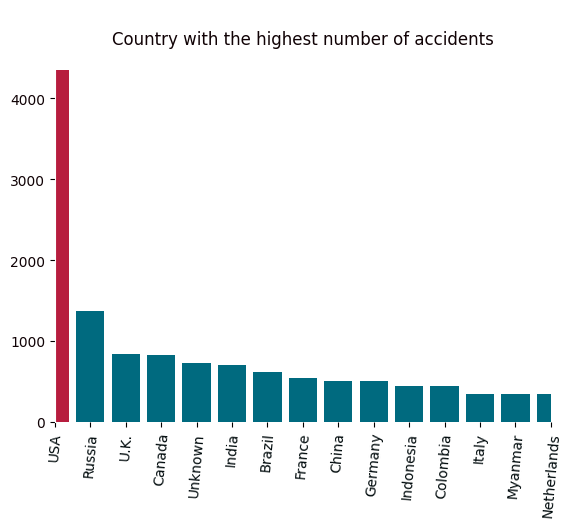

In [ ]:
"""
This code generates a bar chart showing the countries where the most accidents occurred.
Given that the country present in the dataset are 210, and the objective of the graph is
to find the country with the most accidents, the top 15 were selected.
"""
copy=df.copy()
count_c=copy["country"].value_counts()
count_c=count_c.reset_index()
for i in count_c["index"]:
  if i=="United States of America":
    count_c["index"].replace(i,"USA",inplace=True)
  elif i=="United Kingdom":
    count_c["index"].replace(i,"U.K.",inplace=True)
  elif i=="Unknown country":
    count_c["index"].replace(i,"Unknown",inplace=True)

color=["#b71d3e","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f"]
plt.bar(count_c["index"],count_c["country"],color=color)
plt.xlim(count_c["index"][0],count_c["index"][14])
custom_chart(title="\nCountry with the highest number of accidents",degrees=85)
plt.show()

###***2.*** Do accidents happen more frequently on certain days of the week?

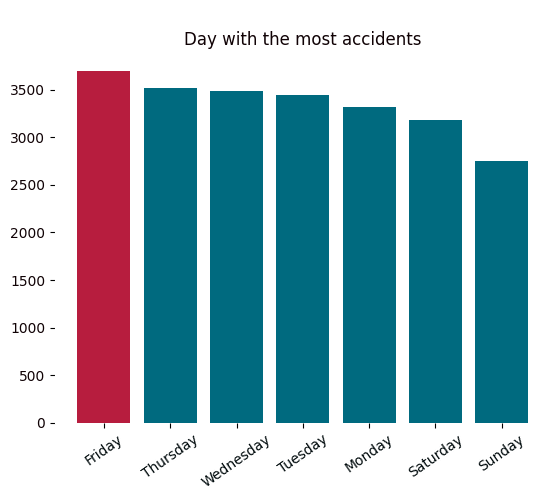

In [ ]:
"""
This chart shows the day of the week when the highest number of accidents occur.
"""
dates=df["date"]
dates["Day"]=dates.dt.dayofweek
day_week=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dates["Day"] = dates["Day"].map(lambda i: day_week[i])
day_counts=dates["Day"].value_counts()

color_lis=["#b71d3e","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f","#006a7f"]
plt.bar(day_counts.index,day_counts.values,color=color_lis)
custom_chart(title="\nDay with the most accidents",degrees=35)
plt.show()

###***3.*** Which operators are the safest?




> We look for the safest operators considering all the data we have:



In [ ]:
tot=safe_operators(df)

The safest operators from 1919-08-02 to 2023-05-15 are 2825 over 5907, that is % 47.8




> It's a big group! Let's narrow the field. Now we will only look at incidents from the last year, 2023.




In [ ]:
"""
We apply a filter to the dataset and call the "safe_operators" function.
With a "for" we create in output a list with the names of the safest operators.
"""
df_2023=df[df["date"]>=datetime(2023, 1, 1)]
op_23=safe_operators(df_2023)
for i in op_23:
  print(f" ▹ {i}")

The safest operators from 2023-01-02 to 2023-05-15 are 35 over 43, that is % 81.4

 ▹ 1982-047 LLC
 ▹ AeromÃ¡s
 ▹ Air Canada
 ▹ Air Transat
 ▹ Angkasa Super Services
 ▹ Asia Cargo Airlines
 ▹ Badr Airlines
 ▹ Bank of Utah Trustee
 ▹ Bar Aviation
 ▹ Belcanto Airlines
 ▹ Cargolux
 ▹ Chartright Air
 ▹ Coulson Aviation
 ▹ Dimonim Air
 ▹ Emirates
 ▹ Fly Air Africa Aviation
 ▹ Flytec SA
 ▹ Haedo Air LLC
 ▹ Helifix Operation
 ▹ Kamaka Air
 ▹ Kush Aviation
 ▹ Lynch Flying Service Inc
 ▹ Mag Aviation, LLC
 ▹ Minnesota Equipment Leasing Services Inc
 ▹ Nasional Global Aviasi
 ▹ Northwestern Air Lease
 ▹ Saudi Arabian
 ▹ SkyDive Mexico
 ▹ SkyUp Airlines, opf Sun Air Company
 ▹ Stavropol City Aviation Sports Club
 ▹ Sudan AF
 ▹ Sudan Government
 ▹ Sudan Police Air Wing
 ▹ TAG
 ▹ Xceed Management Group LLC


###***4.*** Which type of aircraft caused the most deaths?

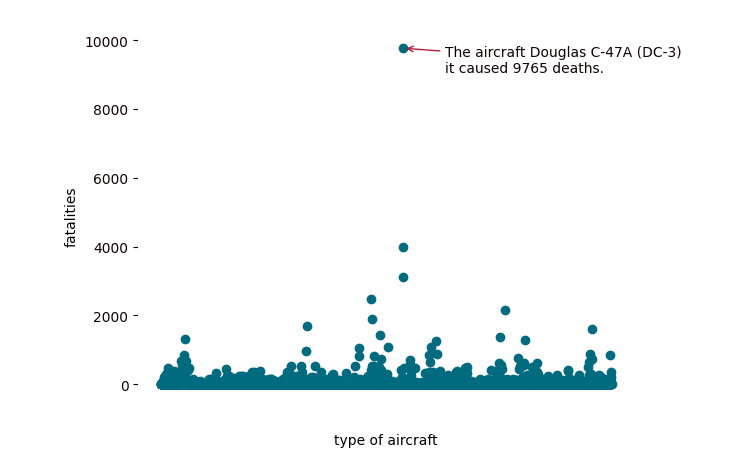

In [ ]:
aircraft=df.groupby("type")["fatalities"].sum()
bad_aircraft(aircraft,labelx="type of aircraft\n")

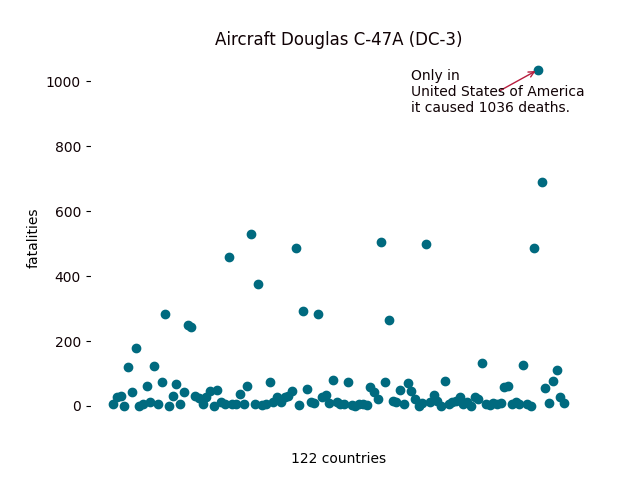

In [ ]:
"""
Now we will do a little insight.
Let's see in which country the aircraft caused the most fatalities.
"""
name_a=aircraft.idxmax()
group=df[df["type"]==aircraft.idxmax()]
type_diff=group.groupby("country")["fatalities"].sum()
number_of_c=len(type_diff.index.unique())
bad_aircraft(type_diff,title=f"\nAircraft {name_a}",labelx=f"{number_of_c} countries\n", part="Only in\n",x_text=80,y_ptext=130)

###***5.*** How did accident evolve after September 11, 2001?


> In all countries **:**



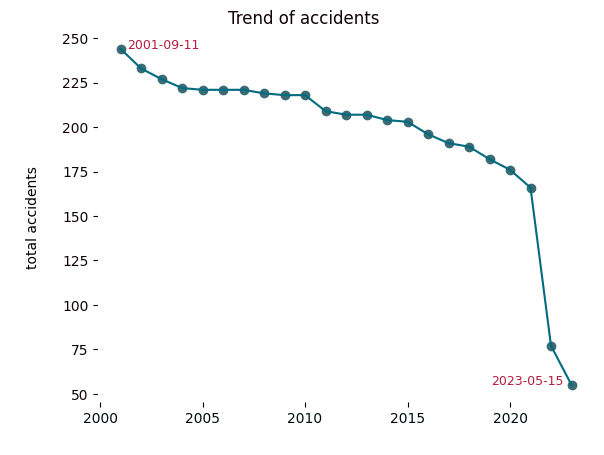

In [ ]:
trend_accident(df)


>In the United States of America **:**



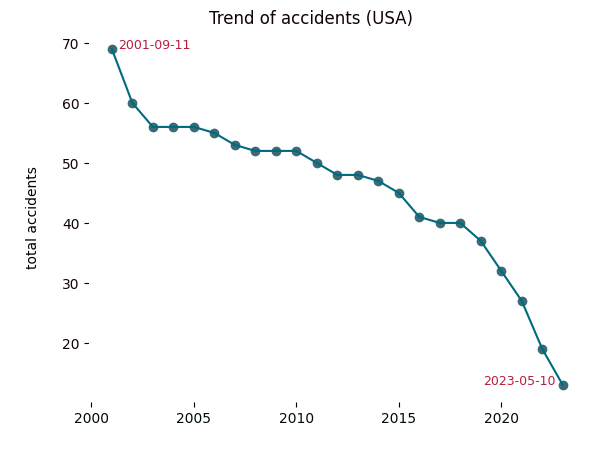

In [ ]:
"""
A little insight into the USA
"""
usa=df[df["country"]=="United States of America"]
trend_accident(usa,p_title="(USA)")

###***6.*** Cartogram representing the number of accidents by country


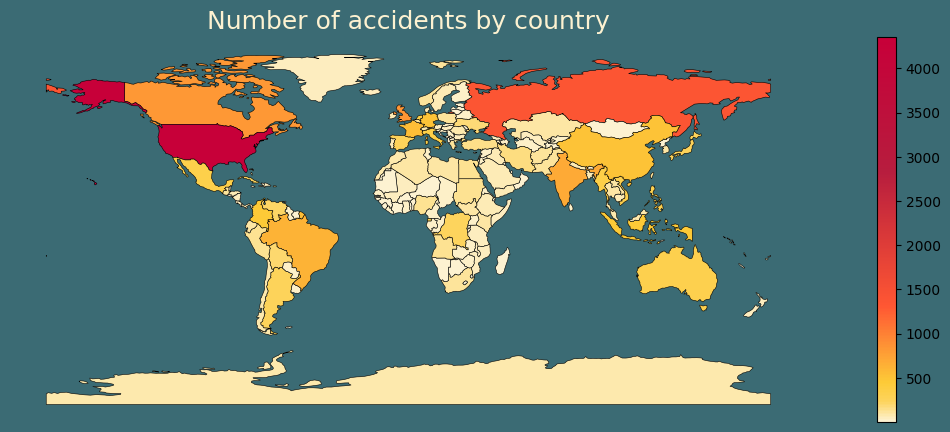

In [ ]:
"""
With this cartogram we can have an overall view
of the number of accidents by country.
"""
colors=[(0,"#FDF2D1"),(0.05,"#FDD45E"),(0.10,"#FDCB37"),(0.30,"#FF5733"),(0.65,"#b71d3e"),(1,"#c70039")]
my_colors=LinearSegmentedColormap.from_list("my_colors", colors)

merge=world.set_index("name").join(df["country"].value_counts())
fig=plt.figure(figsize=(18,5),facecolor="#3B6B74")
ax=fig.add_subplot(111)
merge.plot(column="country", cmap=my_colors, linewidth=0.4,ax=ax,edgecolor="0.0", legend=True)
ax.set_title("Number of accidents by country", fontdict={"fontsize":"18","fontweight":"1","color":"#FDF2D1"})
ax.axis("off")
plt.show()


###***7.*** Comparison between accident trends and fatalities trends

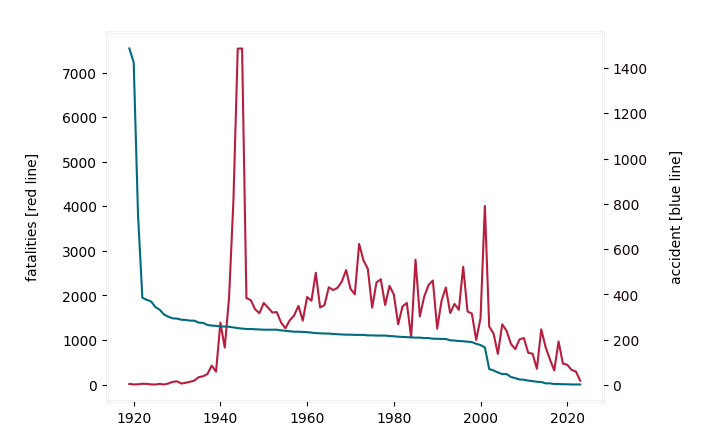

In [ ]:
"""
This comparative line chart can give us an idea of ​​the general trend.
"""
year=df["date"].dt.year.value_counts()
group_d_f=df.groupby(df["date"].dt.year)["fatalities"].sum()

fig,ax1=plt.subplots()
ax1.plot(group_d_f.index,group_d_f.values,color="#b71d3e")
ax2=ax1.twinx()
ax2.plot(group_d_f.index,year.values,color="#006a7f")

custom_chart(title=" ",c_axis_b="white",c_axis_r="white",c_axis_t="white")
ax2.set_ylabel("\naccident [blue line]\n")
ax1.set_ylabel("\nfatalities [red line]\n")
plt.show()

###***8.*** Which type of accident (cat) is most frequent?

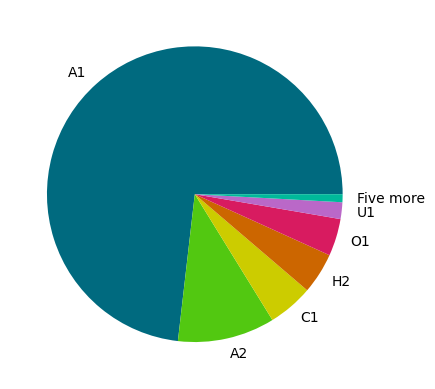

In [ ]:
"""
With this chart it is immediately clear which type of accident is most common.
The "copy" variable is a copy of the dataframe that has already been used in the first graph!
"""
copy
for i in copy["cat"]:
  if i in ['C2', 'H1', 'O2', 'I2', 'I1']:
    copy.replace(i,"Five more",inplace=True)
type_cat=copy["cat"].value_counts()
type_cat=(type_cat/len(df["cat"]))*100
type_cat.plot(kind="pie",colors=["#006a7f","#52C811","#CCCC00","#CC6600","#D81B60","#BA68C8","#00B99A"])
custom_chart()
plt.show()

###***9.*** Type of accident (cat) in the time


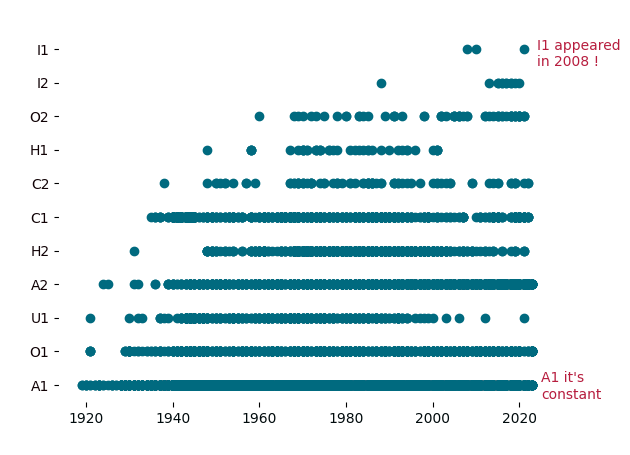

In [ ]:
"""
With this chart we can see how often each (cat) type of accident occurs.
"""

plt.scatter(df["date"].dt.year,df["cat"],color="#006a7f")
custom_chart(degrees=0,title=" ",xlabel=" ",ylabel=" ")
i1=df[df["cat"]=="I1"]
d_i1=i1["date"].dt.year.min()
plt.annotate(f"I1 appeared\nin {d_i1} !",xy=(2024,9.5),color="#b71d3e")
plt.annotate("A1 it's\nconstant",xy=(2025,-0.40),color="#b71d3e")
plt.show()

###Note**:** chart references will be indicated as: [ ***1.*** ]


> The country with the highest number of accidents is the USA. Furthermore, the total number of accidents in this country is extremely high [ ***1.*** ]  [ ***6.*** ]. But there is no need to worry, in fact by observing the charts with the accident trends [ ***5.*** ]  and fatalities trends [ ***7.*** ] we can observe that even in the USA, accidents, are decreasing as other countries trend, the policies adopted so far seem effective!
However, it is advisable, to report a aircraft that appears to be potentially dangerous, as seen in the chart [ ***4.*** ].
Finally, it is good to advise you to delve into the causes of category **I1** because even if this type of accident is not frequent, at the moment, it is also true that, unlike the other categories, it has only been observed for a short time [ ***9.*** ].


*Please remember that this analysis only aims to focus on the strengths and possible critical points of the current situation to air accidents.
With the data at our disposal it is not possible to determine the cause of the phenomena described !*